# Problem 1

Empirical validation of double descent. Start with some imports.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from torch import nn
from torch import Tensor
from torch.optim import SGD, AdamW
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm

In [2]:
plt.style.use('seaborn-v0_8')
plt.rcParams.update({'font.size': 8})

device = "cpu"
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"

### Create data

No need to change this block.

In [3]:
# N samples with D inputs and O outputs
N = 100
D = 8
O = 8

# Training data
x = torch.randn(N, D)
noiselevel = 0.3
y = (1-noiselevel)*x + noiselevel*torch.randn(N, O)

# Test data
N_test = 1000
x_test = torch.randn(N_test, D)
y_test = (1-noiselevel)*x_test + noiselevel*torch.randn(N_test, O)

### Create model

In [4]:
class regression(nn.Module):
    def __init__(self, m: int, d_in: int, d_out: int) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(d_in, m),
            nn.ReLU(),
            nn.Linear(m, m),
            nn.ReLU(),
            nn.Linear(m, d_out),
        )

    def forward(self, X):
        return self.layers(X)

### Train model and validate double descent

In [8]:
def train(model, optimizer, criterion, loader_train):
    list_loss = []

    model.train()
    for Xtrain, ytrain in loader_train:
        optimizer.zero_grad()

        out = model(Xtrain)
        loss = criterion(ytrain, out)
        loss.backward()
        optimizer.step()

        list_loss.append(loss.detach().cpu().item())

    return list_loss

def test(model, criterion, xtest, ytest):
    model.eval()

    with torch.no_grad():
        out = model(xtest)
        loss = criterion(ytest, out)

    return loss.detach().cpu().item()

#### Problem 1.b.

In [6]:
x_test, y_test = x_test.to(device), y_test.to(device)

In [7]:
def trigger_train(
    xtrain: Tensor,
    ytrain: Tensor,
    xtest: Tensor,
    ytest: Tensor,
    values_M: list,
    batch_size: int,
    lr: float=1e-3,
    num_epchs: int = 1000,
    device: str = "cpu"
):
    losses_train = {m: [] for m in values_M}
    losses_val = {m: [] for m in values_M}

    loader_train = DataLoader(
        TensorDataset(xtrain.to(device), ytrain.to(device)),
        batch_size=batch_size,
        shuffle=True
    )

    for M in tqdm(values_M):
        model = regression(M, d_in=D, d_out=O).to(device)
        optimizer = AdamW(model.parameters(), lr=lr)
        criterion = nn.MSELoss()

        for _ in range(num_epchs):
            list_loss_train = train(model, optimizer, criterion, loader_train)
            losses_train[M].extend(list_loss_train)

            losses_val[M].append(test(model, criterion, xtest, ytest))

    return losses_train, losses_val

In [8]:
LR = 1e-3
NUM_EPCHS = 1000
batch_size = 10
values_M = [10, 50, 100]

losses_train, _ = trigger_train(x, y, x_test, y_test, values_M, batch_size, LR, NUM_EPCHS, device)

  0%|          | 0/3 [00:00<?, ?it/s]

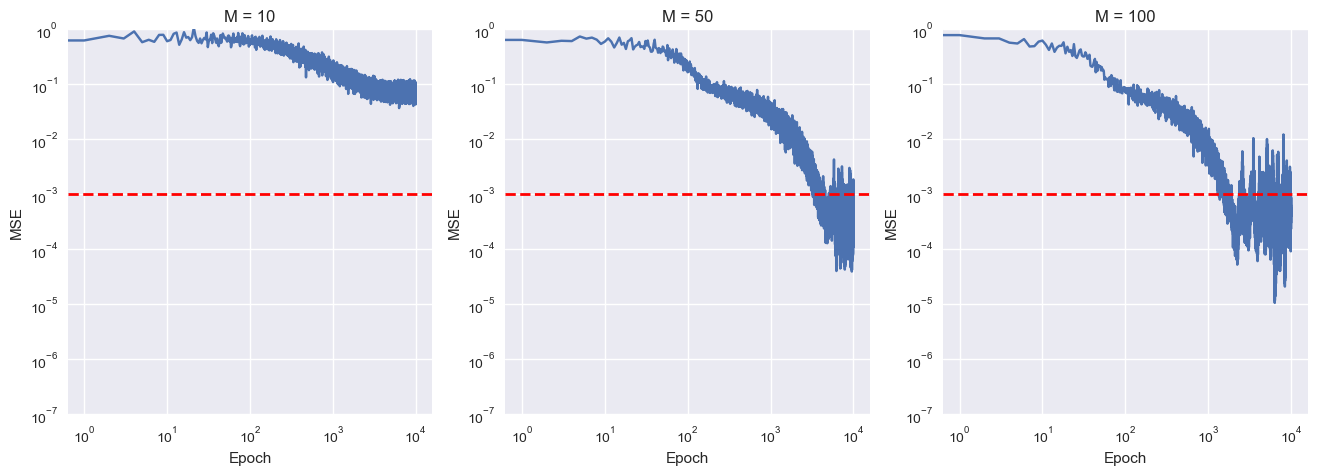

In [9]:
#Plotting hints for (b)

fig = plt.figure(figsize=(16, 5))

for idx, M in enumerate(values_M):

    ax = fig.add_subplot(1, 3, idx + 1)

    ax.plot(losses_train[M])

    ax.set_ylim([10**(-7),1])
    ax.axhline(y=1e-3, color='r', linestyle='--', linewidth=2)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylabel("MSE")
    ax.set_xlabel("Epoch")
    ax.set_title(f"M = {M}")

#### Problem 1.c.

In [10]:
batch_size = N
LR = 5e-3
NUM_EPCHS = 1000
values_M = range(10, 200, 10)

losses_train, losses_val = trigger_train(x, y, x_test, y_test, values_M, batch_size, LR, NUM_EPCHS, device)

  0%|          | 0/19 [00:00<?, ?it/s]

In [11]:
losses = []

for k, loss in losses_train.items():
    losses.append({
        'M': k,
        'mse': loss[-1],
        'loss_type': 'train'
    })

for k, loss in losses_val.items():
    losses.append({
        'M': k,
        'mse': loss[-1],
        'loss_type': 'val'
    })

df_loss = pd.DataFrame.from_records(losses)
df_loss.head()

,M,mse,loss_type
0,10,0.056471,train
1,20,0.019583,train
2,30,0.001037,train
3,40,0.000105,train
4,50,0.000005,train


Text(0.5, 0, 'Number of neurons')

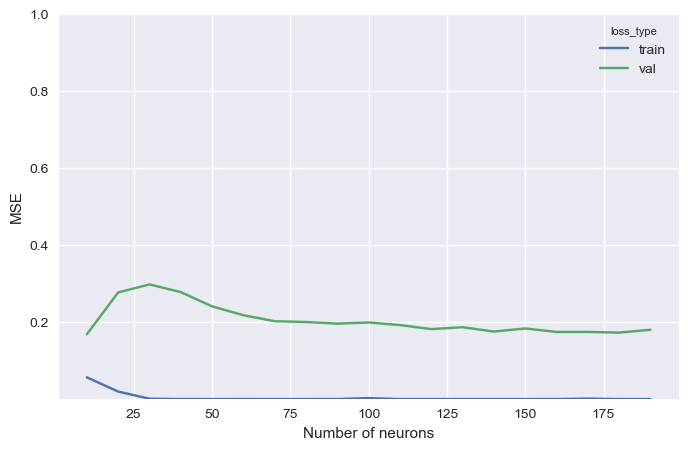

In [12]:
#Plotting hints for (c)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

sns.lineplot(data=df_loss, x='M', y='mse', hue='loss_type')

ax.set_ylim([10**(-3),1])
ax.set_ylabel("MSE")
ax.set_xlabel("Number of neurons")

In [13]:
df_loss_val = df_loss[df_loss['loss_type'] == 'val']
interpolation_thres = df_loss_val[df_loss_val['mse'] == df_loss_val['mse'].max()]['M'].item()

print(f"Interpolation threshold: {interpolation_thres}")

Interpolation threshold: 30


### Having more data can hurt

Just repeat the same experiment with more data for two manually chosen K.

In [16]:
N = 200
x = torch.randn(N, D)
y = (1-noiselevel)*x + noiselevel*torch.randn(N, O)

M_interpol = 30
M_overparam = 180
values_M = [M_interpol, M_overparam]

batch_size = N

_, losses_val = trigger_train(x, y, x_test, y_test, values_M, batch_size, LR, NUM_EPCHS, device)

  0%|          | 0/2 [00:00<?, ?it/s]

In [17]:
losses = []

for k, loss in losses_val.items():
    losses.append({
        'M': k,
        'mse': loss[-1],
    })

df_loss_2 = pd.DataFrame.from_records(losses)
df_loss_2['data'] = 'more'
df_loss_2.head()

,M,mse,data
0,30,0.205094,more
1,180,0.179645,more


In [18]:
df_tmp = df_loss[(df_loss['M'].isin(values_M)) & (df_loss['loss_type'] == 'val')]\
    .copy()\
    .drop(columns=['loss_type'])
df_tmp['data'] = 'less'

df_final = pd.concat([df_tmp, df_loss_2])
df_final.head()

,M,mse,data
21,30,0.297619,less
36,180,0.172570,less
0,30,0.205094,more
1,180,0.179645,more


<Axes: xlabel='M', ylabel='mse'>

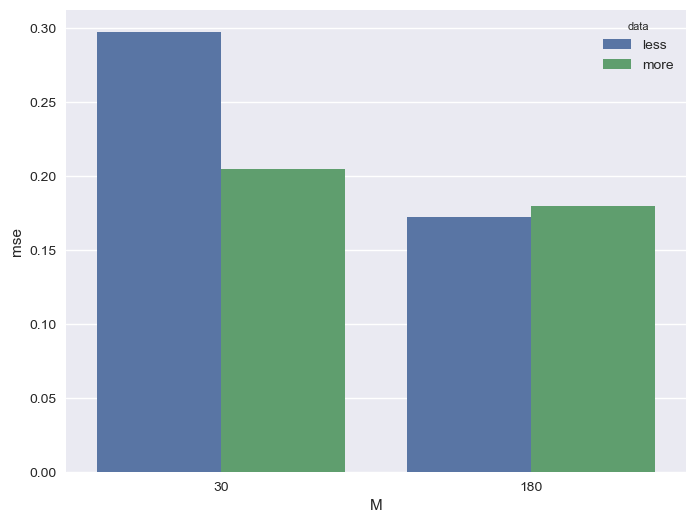

In [19]:
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)
sns.barplot(data=df_final, x='M', y='mse', hue='data')

# Problem 2

Implicit regularization of SGD.

### Create data

In [12]:
# Training samples
N = 200
x = torch.rand(N,3)*2. - 1.
y = ((0.4*torch.sin(x[:,0])*x[:,1]**2. - 0.7*x[:,2]**3.)* torch.exp(-torch.sum(x**2.,1)/15.)).resize(N,1)
# Add some noise
dist = torch.distributions.StudentT(4, 0, 1)
y = y + 0.05*dist.rsample(torch.Size([N,1]))

# Test samples
# Storing also the non-noisy version for cleaner plotting
M = 10000
x_test = torch.rand(M,3)*2. - 1.
y_test = ((0.4*torch.sin(x_test[:,0])*x_test[:,1]**2. - 0.7*x_test[:,2]**3.)* torch.exp(-torch.sum(x_test**2.,1)/15.)).resize(M,1) + 0.05*dist.rsample(torch.Size([M,1]))

/Users/macos/miniforge3/envs/py/lib/python3.10/site-packages/torch/_tensor.py:836: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


In [13]:
x, y = x.to(device), y.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

### Model

The same as in previous exercise.

In [24]:
class regression(nn.Module):
    def __init__(self, m: int, d_in: int, d_out: int) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(d_in, m),
            nn.ReLU(),
            nn.Linear(m, m),
            nn.ReLU(),
            nn.Linear(m, m),
            nn.ReLU(),
            nn.Linear(m, m),
            nn.ReLU(),
            nn.Linear(m, m),
            nn.ReLU(),
            nn.Linear(m, d_out),
        )

    def forward(self, X):
        return self.layers(X)

### Computing the required norms

In [ ]:

def get_grad(model: nn.Module) -> Tensor:
    grads = []
    for param in model.parameters():
        grads.append(param.grad.view(-1))
    grads = torch.cat(grads)

    return grads

def gradient_norms(model, objective, x, y, data_loader, lr):
    optimizer = SGD(model.parameters(), lr=lr)

    # Calculate gradient w.r.t full data
    optimizer.zero_grad()
    out = model(x)
    loss = objective(y, out)
    loss.backward()

    grads_full = get_grad(model) / x.shape[0]

    # Calculate gradient at each mini-batch
    total_grads_norm = 0
    n = 0
    for Xtrain, ytrain in data_loader:
        optimizer.zero_grad()
        out = model(Xtrain)
        loss = objective(ytrain, out)
        loss.backward()

        grads_minibatch = get_grad(model) / Xtrain.shape[0]
        total_grads_norm += torch.norm(grads_minibatch - grads_full)**2

        n += 1

    # Calculate the final
    grad_diff_norm = total_grads_norm / n

    return grad_norm, grad_diff_norm

### Main loop

In [ ]:
num_epchs = 800
batch_size = 20
M = 50
values_lr = [0.02, 0.04, 0.08, 0.16]
d_in, d_out = x.shape[-1], y.shape[-1]

losses_train = {lr: [] for lr in values_lr}
losses_test = {lr: [] for lr in values_lr}
grads = {lr: [] for lr in values_lr}
grads_final = {lr: [] for lr in values_lr}

loader_train = DataLoader(
    TensorDataset(x.to(device), y.to(device)),
    batch_size=batch_size,
    shuffle=True
)

for lr in tqdm(values_lr):
    model = regression(M, d_in=d_in, d_out=d_out).to(device)
    
    criterion = nn.MSELoss()

    for _ in range(num_epchs):
        list_loss_train = train(model, optimizer, criterion, loader_train)

        # Train
        model.train()
        for Xtrain, ytrain in loader_train:
            optimizer.zero_grad()

            out = model(Xtrain)
            loss = criterion(ytrain, out)
            loss.backward()
            optimizer.step()

            list_loss.append(loss.detach().cpu().item())

        # Test
        model.eval()

        with torch.no_grad():
            out = model(xtest)
            loss = criterion(ytest, out)
        losses_train[lr].extend(list_loss_train)

In [ ]:
df_lr = pd.DataFrame(losses_train)
df_lr['step'] = range(len(df_lr))

df_lr = df_lr.melt(id_vars='step', value_vars=values_lr, value_name='mse', var_name='lr')\

df_lr.head()

### Reporting


In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)

sns.lineplot(data=df_lr, x='step', y='mse', hue='lr', ax=ax)